#### pyWaPOR vs. WaPOR

In this notebook we'll make an comparison between dekadal Evapotranspiration data from WaPOR and from pyWaPOR.

First we install pywapor, in case it's not installed yet.

In [ ]:
!pip install pywapor==2.4.1 --quiet

Next we'll define a couple of basic variables, which were explained in the introduction notebook.

In [1]:
import pywapor

project_folder = r"/Users/hmcoerver/pywapor_notebooks"
latlim = [28.9, 29.7]
lonlim = [30.2, 31.2]
startdate = "2021-07-01"
enddate = "2021-07-11"

Then we run `pre_et_look`, to generate an ET map for the first dekad of July 2021. If you already ran another notebook on this instance, you should already have all the data in your RAW folder and this should take only a few minutes.

In [2]:
ds, fh = pywapor.pre_et_look.main(project_folder, startdate, enddate, latlim, lonlim)

> PRE_ET_LOOK
    # ndvi
    --> Downloading MOD13.
Tile: 3 / 3: 0.00Bytes [00:00, ?Bytes/s]
    --> Downloading MYD13.
Tile: 1 / 1: 0.00Bytes [00:00, ?Bytes/s]
    --> Resampling resolution is ~205 meter.
    --> Resampling datasets.
    --> Calculating composites.
    # p_24
    --> Downloading CHIRPS.
Tile: 11 / 11: 0.00Bytes [00:00, ?Bytes/s]
    --> Resampling datasets.
    --> Calculating composites.
    # se_root
    > PRE_SE_ROOT
        # ndvi
        --> Downloading MOD13.
Tile: 3 / 3: 0.00Bytes [00:00, ?Bytes/s]
        --> Downloading MYD13.
Tile: 1 / 1: 0.00Bytes [00:00, ?Bytes/s]
        --> Resampling resolution is ~205 meter.
        --> Resampling datasets.
        # lst
        --> Downloading MOD11.
Tile: 11 / 11: 0.00Bytes [00:00, ?Bytes/s]
        --> Downloading MYD11.
Tile: 11 / 11: 0.00Bytes [00:00, ?Bytes/s]
        --> Resampling datasets.
        > METEO
            # t_air_i
            --> Downloading GEOS5 (3-hourly), t2m.
Tile: 35 / 35: 0.00Bytes [00:00, 

Then we run `et_look`. In order to get a good match with WaPOR we'll adjust some of the default constants used by pyWaPOR. The WaPOR dataset is generated with different values for these constants per region, see the WaPOR documentation for more information.

In [3]:
pywapor_files = pywapor.et_look.main(ds, export_vars = ["et_24_mm"], export_to_tif = True)
pywapor_file = pywapor_files["et_24_mm"][0]

--> Running ETLook_v2


--> Saving outputs.


Now that we have the pyWaPOR ET map, we still need the WaPOR map in order to make a comparison. We can download it like this.

In [4]:
import os

raw_folder = os.path.join(project_folder, "RAW")
dl_args = (raw_folder, latlim, lonlim, startdate, enddate, "L1_AETI_D")

wapor_file = pywapor.collect.WAPOR.Get_Layer(*dl_args)[0]

For the rest of this notebook we'll work on comparing the values within these two geoTIFFs.

In [5]:
print(f"wapor_file   : {os.path.split(wapor_file)[-1]}")
print(f"pywapor_file : {os.path.split(pywapor_file)[-1]}")

wapor_file   : L1_AETI_D_WAPOR_DEKAD_2021.07.01.tif
pywapor_file : et-24-mm_-_-_10_2021.07.01.tif


We start by opening the data and comparing some basic information. From the geotransforms of the geoTIFFs we can see that the pixel sizes are similar, but not identical. Furthermore, the number of pixels is unequal as well.

In [6]:
wapor_data = pywapor.general.processing_functions.open_as_array(wapor_file)
wapor_geot = pywapor.general.processing_functions.get_geoinfo(wapor_file)[0]

pywapor_data = pywapor.general.processing_functions.open_as_array(pywapor_file)
pywapor_geot = pywapor.general.processing_functions.get_geoinfo(pywapor_file)[0]

print(f"pixel_size pywapor  : {pywapor_geot[1]:.4f}")
print(f"pixel_size wapor    : {wapor_geot[1]:.4f}")
print(f"array_shape pywapor : {pywapor_data.shape}")
print(f"array_shape wapor   : {wapor_data.shape}")

pixel_size pywapor  : 0.0020
pixel_size wapor    : 0.0022
array_shape pywapor : (408, 510)
array_shape wapor   : (539, 629)


We'll have to do something about these differences, but let's first create some maps to get a better idea of what we are dealing with.

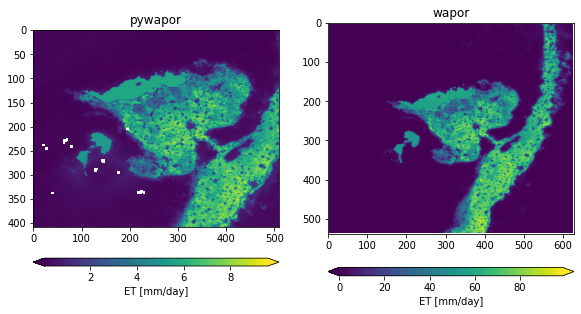

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(1)
fig.clf()
fig.set_size_inches(9.69, 5.27)
axs = fig.subplots(1, 2, sharex=False, sharey=False).flatten()

pywapor.post_et_look.plot_img(axs[0], pywapor_data, "pywapor", "ET [mm/day]")
pywapor.post_et_look.plot_img(axs[1], wapor_data, "wapor", "ET [mm/day]")

You'll see that the spatial extent of the WaPOR geoTIFF is larger than pyWaPORs, e.g. clearly a larger part of the Nile delta is visible on the WaPOR map. This shouldn't be a surprise though, as we've just seen that (1) the WaPOR pixels are larger and (2) the WaPOR geoTIFF has more pixels.

Nevertheless, in order to really compare the two files, we'll have to reproject one of them to match all the pixels with eachother. We'll reproject the WaPOR file to match with the pyWaPOR file using a nearest-neighbor interpolation.

In [8]:
ds = pywapor.general.processing_functions.reproject_dataset_example(wapor_file, pywapor_file)

wapor_data = pywapor.general.processing_functions.open_as_array(ds)
wapor_geot = pywapor.general.processing_functions.get_geoinfo(ds)[0]

print(f"pixel_size pywapor  : {pywapor_geot[1]:.4f}")
print(f"pixel_size wapor    : {wapor_geot[1]:.4f}")
print(f"array_shape pywapor : {pywapor_data.shape}")
print(f"array_shape wapor   : {wapor_data.shape}")

pixel_size pywapor  : 0.0020
pixel_size wapor    : 0.0020
array_shape pywapor : (408, 510)
array_shape wapor   : (408, 510)


Now the pixels have the same size and the arrays have the same shape (i.e. the same amount of pixels).

In the figure we've created earlier, you might also have noticed that the ET values on the WaPOR map were extremely high compared to the pyWaPOR map. As you can read in the WaPOR documentation, we need to apply a scale-factor of 0.1 to the pixel values to get the correct values.

In [9]:
wapor_data *= 0.1

Now that we have reprojected the data and applied the scale-factor, lets plot the maps again.

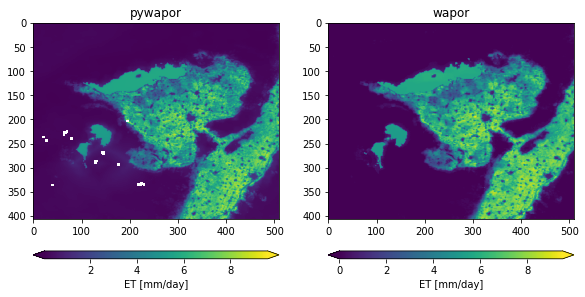

In [10]:
fig = plt.figure(2)
fig.clf()
fig.set_size_inches(9.69, 5.27)
axs = fig.subplots(1, 2, sharex=False, sharey=False).flatten()

pywapor.post_et_look.plot_img(axs[0], pywapor_data, "pywapor", "ET [mm/day]")
pywapor.post_et_look.plot_img(axs[1], wapor_data, "wapor", "ET [mm/day]")

You'll see that the spatial extent of the two maps and the range of the ET values is similar now. The pyWaPOR file contains some pixels without any data though (the white patches). To make a fair comparison, we'll mask those pixels in the WaPOR dataset as well. 

In [11]:
import numpy as np

mask = np.any([np.isnan(pywapor_data), np.isnan(wapor_data)], axis = 0)
pywapor_data[mask] = np.nan
wapor_data[mask] = np.nan

pywapor_data_1d = pywapor_data[~mask].flatten()
wapor_data_1d = wapor_data[~mask].flatten()

print(f"array_shape pywapor : {pywapor_data_1d.shape}")
print(f"array_shape wapor   : {wapor_data_1d.shape}")

array_shape pywapor : (207937,)
array_shape wapor   : (207937,)


Now we have 207236 values per dataset to compare with eachother.

Let's plot our maps again, this time fixing the colorbars of the two maps to be identical.

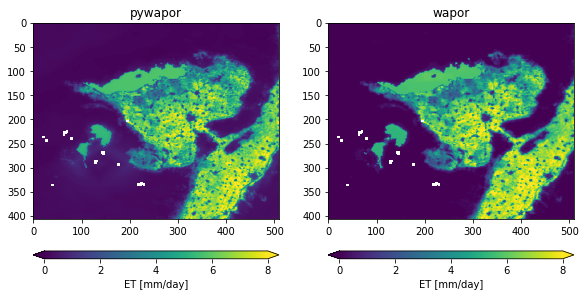

In [12]:
fig = plt.figure(3)
fig.clf()
fig.set_size_inches(9.69, 5.27)
axs = fig.subplots(1, 2, sharex=False, sharey=False).flatten()

pywapor.post_et_look.plot_img(axs[0], pywapor_data, "pywapor", "ET [mm/day]", cb_limits = (0.0, 8.0))
pywapor.post_et_look.plot_img(axs[1], wapor_data, "wapor", "ET [mm/day]", cb_limits = (0.0, 8.0))

The maps look very similar, although it looks like the WaPOR values are slightly higher. we can also calculate some statistics now.

In [13]:
r = pywapor.post_et_look.calc_pearson_correlation([pywapor_data_1d, wapor_data_1d])[0]
nse = pywapor.post_et_look.calc_nash_sutcliffe([pywapor_data_1d, wapor_data_1d])[0]
rmse = pywapor.post_et_look.calc_rmse([pywapor_data_1d, wapor_data_1d])[0]

print(f"r   : {r:.3f}")
print(f"nse : {nse:.3f}")
print(f"rmse: {rmse:.3f} [mm/day]")

r   : 0.978
nse : 0.953
rmse: 0.596 [mm/day]


And create a scatterplot.

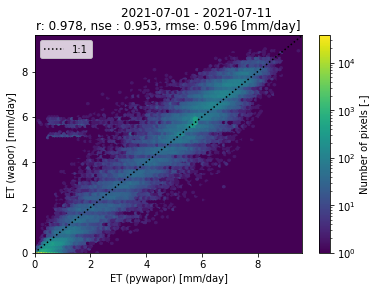

In [14]:
fig = plt.figure(4)
fig.clf()
ax = fig.gca()

pywapor.post_et_look.plot_hexbin(ax, [pywapor_data_1d, wapor_data_1d], 
                                 xlabel = "ET (pywapor) [mm/day]", 
                                 ylabel = "ET (wapor) [mm/day]",
                                 title = f"r: {r:.3f}, nse : {nse:.3f}, rmse: {rmse:.3f} [mm/day]")

title = fig.suptitle(f"{startdate} - {enddate}")

Although there is some variance, the two maps are very similar. `et_look` is identical to the model used to create the WaPOR data, but `pre_et_look` is not. The solar-radiation (ra_24) product used in pyWaPOR is differnt from WaPOR as well. This variance can thus mainly be explained by differences in the preprocessing of the `et_look` input data.